Use adaboost, Gradient Tree Boosting and xgboosting

# NOTES:
Der er nogle ting du skal tilbage og havde styr på. 

Baglens:

- Du skal have flere variabler med herover den først runde feature selection skal kun være helt grov ect vægle mellem log eller ike log ect.
- Der er pludseligt en helt masse missing i dit y!? wth! får lige styr på den kat..
- i forgående gem df som goepandas.dataframe i pickle
- i forgående gem df (- geometry) som padas.dataframe i csv
- ændre navn fatilities i forgående og lav også en logged version.
- Se generelt din estimation for hvad der giver mening som logged...

forlens:

- 1000 random less-unbalanced xgboosts to get a distribution of metric results
- tree graph
- world map of predict vs true. (proba vs log(best) t+1 or pred vs binary_best t +1)
- world map of diff between binary pred and true.
- Use the true hold-out-set.
- Robustness test with only new onsets
- you can easely do basian correction: even country (or something) specific

$$P(død)=\frac{xgboost\_est\_(dist) * country\_mean }{xgboost\_est\_(dist) * country\_mean + (1-xgboost\_est\_(dist)) * (1-country\_mean) }$$

men hvis du vil gøre det med dists kan du vel ikke bruge $1-$..
- tjek if your model gets worse the more years we move away from 2005

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb 
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, average_precision_score, recall_score, precision_recall_curve, roc_auc_score, roc_curve, precision_score, accuracy_score
from sklearn.utils.fixes import signature


In [2]:

pkl_file = open('chosen_df.pkl', 'rb')

df = pickle.load(pkl_file)

pkl_file.close()

df.dropna(inplace = True) # do to some unknown fuckery in the last script.. to fix later

In [3]:

# Balanced: 

# df_train_1 = df_train[df_train['lead_binary_best'] == 1]
# df_train_0 = df_train[df_train['lead_binary_best'] == 0].sample(df_train_1.shape[0])

# df_train_ss = pd.concat([df_train_0,df_train_1])

#df = df_train_ss.sample(10000)

# The functions:

**Du mangler stadigt at gemme din "posterior" aka alle forudsiagte y_tilde (i out_years modellerne.)**

In [4]:
# dict of metrics

def cons_dict_of_metric():
    # Construct the empty dict of matrics and other stuff
    dict_of_metrics = {}
    dict_of_metrics['auc'] = []
    dict_of_metrics['ap'] = []

    dict_of_metrics['recall50'] = []
    dict_of_metrics['recall75'] = []
    dict_of_metrics['recall95'] = []

    dict_of_metrics['precision50'] = []
    dict_of_metrics['precision75'] = []
    dict_of_metrics['precision95'] = []
    
    dict_of_metrics['accuracy50'] = []
    
    #roc,rp, feature imp
    
    dict_of_metrics['roc'] = []
    dict_of_metrics['prc'] = []
    dict_of_metrics['feature_imp'] = []
    
    return(dict_of_metrics)

In [5]:
def in_years_estimation(sample_sizs = 100):
    
    # if you could multiprocesse it. like multiple chains. that would be nice..
    
    # Hold out years:
    df_test_years = df[df['year']>2005].copy()
    df_train_years = df[df['year']<=2005].copy()

    #radnom seeds for loop (culd do without, but it eases intpr.)
    random_seeds = np.random.randint(1000,9999,1000)

    # dict of metrics
    dict_of_metrics = cons_dict_of_metric()    

    # add more and roc + ap-curve data later on.
    # And feature imp!


    # feature and target labels:

    X_labels = ['fatilities_country_year', 'log_best', 'log_country_area_sum',
            'low_ratio_light', 'nearest_conflict', 'nlights_calib_mean',
            'past_conflicts', 'excluded_binary', 'petroleum_full',
            'diff_median_light','binary_best', 'pop_cell_dens', 
            'log_interp_pop_gpw_sum','conflict_country_year']

    y_label = 'lead_binary_best'

    df_train_years_1 = df_train_years[df_train_years['lead_binary_best'] == 1] # events

    #for loop
    for i in range(sample_sizs):

        # The data:
        # the non_events! rigth now 1000 percent
        df_train_years_0 = df_train_years[df_train_years['lead_binary_best'] == 0].sample(df_train_years_1.shape[0], random_state = random_seeds[i])

        #Merge events and non-events; rigth now 10/100
        df_train_years_01 = pd.concat([df_train_years_0,df_train_years_1])

        # dfine X and y
        X = df_train_years_01[X_labels]

        y = df_train_years_01[y_label]

        # test_train: TEMP:
        # Create the training and test sets
        X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=random_seeds[i])


        # the model
        # Instantiate the XGBClassifier: xg_cl
        xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, seed=random_seeds[i])

        # Fit the classifier to the training set
        xg_cl.fit(X_train, y_train)

        # Predict the labels of the test set: preds
        preds = xg_cl.predict_proba(X_test)
        
        preds50 = (preds[:,1] >= 0.5)*1 # binary class with thresshold at 0.5 (standart)
        preds75 = (preds[:,1] >= 0.75)*1 # binary class with thresshold at 0.75 (standart)
        preds95 = (preds[:,1] >= 0.95)*1 # binary class with thresshold at 0.95 (standart)

        dict_of_metrics['ap'].append(average_precision_score(y_test,preds[:,1]))
        dict_of_metrics['auc'].append(roc_auc_score(y_test,preds[:,1]))

        dict_of_metrics['recall50'].append(recall_score(y_test, preds50))
        dict_of_metrics['recall75'].append(recall_score(y_test, preds75))
        dict_of_metrics['recall95'].append(recall_score(y_test, preds95))

        dict_of_metrics['precision50'].append(precision_score(y_test, preds50))
        dict_of_metrics['precision75'].append(precision_score(y_test, preds75))
        dict_of_metrics['precision95'].append(precision_score(y_test, preds95))
        
        dict_of_metrics['accuracy50'].append(accuracy_score(y_test,preds50))
        
        dict_of_metrics['prc'].append(precision_recall_curve(y_test,preds[:,1]))
        dict_of_metrics['roc'].append(roc_curve(y_test, preds[:, 1]))
    
        dict_of_metrics['feature_imp'].append(xg_cl.feature_importances_)

        print(i, end='_')

    return(dict_of_metrics)

In [6]:
def out_years_estimation(sample_size = 100, balance_parameter = 1):    
    
    # Hold out years:
    df_test_years = df[df['year']>2005].copy()
    df_train_years = df[df['year']<=2005].copy()

    #radnom seeds for loop (culd do without, but it eases intpr.)
    random_seeds = np.random.randint(1000,9999,1000)

    # dict of metrics
    dict_of_metrics = cons_dict_of_metric()    


    # feature and target labels:

    X_labels = ['fatilities_country_year', 'log_best', 'log_country_area_sum',
            'low_ratio_light', 'nearest_conflict', 'nlights_calib_mean',
            'past_conflicts', 'excluded_binary', 'petroleum_full',
            'diff_median_light','binary_best', 'pop_cell_dens', 
            'log_interp_pop_gpw_sum','conflict_country_year']

    y_label = 'lead_binary_best'

    df_train_years_1 = df_train_years[df_train_years['lead_binary_best'] == 1] # events


    #for loop
    for i in range(sample_size):

        # The data:
        # the non_events! rigth now 1000 percent
        df_train_years_0 = df_train_years[df_train_years['lead_binary_best'] == 0].sample(df_train_years_1.shape[0]*balance_parameter, random_state = random_seeds[i]) 
        # you shoul dmeak one with *1 and *20 manke it an input in the function 

        #Merge events and non-events; rigth now 10/100
        df_train_years_01 = pd.concat([df_train_years_0,df_train_years_1])

        # dfine X and y
        X_train = df_train_years_01[X_labels]

        y_train = df_train_years_01[y_label]

        # test_train: TEMP:
        # Create the training and test sets
        #X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=random_seeds[i])

        X_test = df_test_years[X_labels]
        y_test = df_test_years[y_label]

        # the model
        # Instantiate the XGBClassifier: xg_cl
        xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, seed=random_seeds[i])

        # Fit the classifier to the training set
        xg_cl.fit(X_train, y_train)

        # Predict the labels of the test set: preds
        preds = xg_cl.predict_proba(X_test)

        preds50 = (preds[:,1] >= 0.5)*1 # binary class with thresshold at 0.5 (standart)
        preds75 = (preds[:,1] >= 0.75)*1 # binary class with thresshold at 0.75 (standart)
        preds95 = (preds[:,1] >= 0.95)*1 # binary class with thresshold at 0.95 (standart)

        dict_of_metrics['ap'].append(average_precision_score(y_test,preds[:,1]))
        dict_of_metrics['auc'].append(roc_auc_score(y_test,preds[:,1]))

        dict_of_metrics['recall50'].append(recall_score(y_test, preds50))
        dict_of_metrics['recall75'].append(recall_score(y_test, preds75))
        dict_of_metrics['recall95'].append(recall_score(y_test, preds95))

        dict_of_metrics['precision50'].append(precision_score(y_test, preds50))
        dict_of_metrics['precision75'].append(precision_score(y_test, preds75))
        dict_of_metrics['precision95'].append(precision_score(y_test, preds95))
        
        dict_of_metrics['accuracy50'].append(accuracy_score(y_test,preds50))
        
        dict_of_metrics['prc'].append(precision_recall_curve(y_test,preds[:,1]))
        dict_of_metrics['roc'].append(roc_curve(y_test, preds[:, 1]))
    
        dict_of_metrics['feature_imp'].append(xg_cl.feature_importances_)

        print(i, end='_')

    return(dict_of_metrics)

In [7]:
def out_years_estimation_onsets(sample_size = 100, balance_parameter = 1):   
    
    df_ongoing = df[(df['lead_binary_best']==1)&(df['binary_best'] == 1)]
    df_onset = df[~((df['lead_binary_best']==1)&(df['binary_best'] == 1))]
    
    print('Number of observation/conflicts discarded: {}'.format(df_ongoing.shape[0]))
    print('Number of observation preserved: {}'.format(df_onset.shape[0]))
    print('Number of conflicts preserved: {}'.format(df_onset[df_onset['lead_binary_best'] == 1].shape[0]))
    
    # Hold out years:
    df_test_years = df_onset[df_onset['year']>2005].copy()
    df_train_years = df_onset[df_onset['year']<=2005].copy()

    #radnom seeds for loop (culd do without, but it eases intpr.)
    random_seeds = np.random.randint(1000,9999,1000)

    # dict of metrics
    dict_of_metrics = cons_dict_of_metric()    


    # add more and roc + ap-curve data later on.
    # And feature imp!


    # feature and target labels:

    X_labels = ['fatilities_country_year', 'log_best', 'log_country_area_sum',
            'low_ratio_light', 'nearest_conflict', 'nlights_calib_mean',
            'past_conflicts', 'excluded_binary', 'petroleum_full',
            'diff_median_light','binary_best', 'pop_cell_dens', 
            'log_interp_pop_gpw_sum','conflict_country_year']

    y_label = 'lead_binary_best'
    
    
    df_train_years_1 = df_train_years[df_train_years['lead_binary_best'] == 1] # events


    #for loop
    for i in range(sample_size):

        # The data:
        # the non_events! rigth now 1000 percent
        df_train_years_0 = df_train_years[df_train_years['lead_binary_best'] == 0].sample(df_train_years_1.shape[0]*balance_parameter, random_state = random_seeds[i]) 
        # you shoul dmeak one with *1 and *20 manke it an input in the function 

        #Merge events and non-events; rigth now 10/100
        df_train_years_01 = pd.concat([df_train_years_0,df_train_years_1])

        # dfine X and y
        X_train = df_train_years_01[X_labels]

        y_train = df_train_years_01[y_label]

        # test_train: TEMP:
        # Create the training and test sets
        #X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=random_seeds[i])

        X_test = df_test_years[X_labels]
        y_test = df_test_years[y_label]

        # the model
        # Instantiate the XGBClassifier: xg_cl
        xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, seed=random_seeds[i])

        # Fit the classifier to the training set
        xg_cl.fit(X_train, y_train)

        # Predict the labels of the test set: preds
        preds = xg_cl.predict_proba(X_test)

        preds50 = (preds[:,1] >= 0.5)*1 # binary class with thresshold at 0.5 (standart)
        preds75 = (preds[:,1] >= 0.75)*1 # binary class with thresshold at 0.75 (standart)
        preds95 = (preds[:,1] >= 0.95)*1 # binary class with thresshold at 0.95 (standart)

        dict_of_metrics['ap'].append(average_precision_score(y_test,preds[:,1]))
        dict_of_metrics['auc'].append(roc_auc_score(y_test,preds[:,1]))

        dict_of_metrics['recall50'].append(recall_score(y_test, preds50))
        dict_of_metrics['recall75'].append(recall_score(y_test, preds75))
        dict_of_metrics['recall95'].append(recall_score(y_test, preds95))

        dict_of_metrics['precision50'].append(precision_score(y_test, preds50))
        dict_of_metrics['precision75'].append(precision_score(y_test, preds75))
        dict_of_metrics['precision95'].append(precision_score(y_test, preds95))

        dict_of_metrics['accuracy50'].append(accuracy_score(y_test,preds50))
        
        dict_of_metrics['prc'].append(precision_recall_curve(y_test,preds[:,1]))
        dict_of_metrics['roc'].append(roc_curve(y_test, preds[:, 1]))
    
        dict_of_metrics['feature_imp'].append(xg_cl.feature_importances_)

        print(i, end='_')

    return(dict_of_metrics)

## plot functions:

In [8]:

def dist_point_plot(dict_of_metrics, metric, color, title = 'Title', show = True):

    label = metric + ': ' + str(np.mean(dict_of_metrics[metric]).round(3))
    
    plt.hist(dict_of_metrics[metric], density=True, label = label, alpha = 0.5, color = color)
    sns.kdeplot(dict_of_metrics[metric], color = color)
    
    plt.title(title, fontsize = 14)
    
    plt.legend()
    plt.yticks([])
    sns.despine(left=True)
    plt.xlabel('metric score', fontsize = 12)
    
    if show == True:
    
        plt.show()


In [9]:
def auc_plot(dict_of_metrics, color = 'C0'):
    
    plt.figure(figsize=[15,5])
    
    metric = 'auc'
    title = metric + ' distrubtion'
    
    dist_point_plot(dict_of_metrics, metric, color, title)
    
    
def ap_plot(dict_of_metrics, color = 'C1'):
        
    plt.figure(figsize=[15,5])
    
    metric = 'ap'
    title = 'Avarega Precision (presicion-recall rate) distrubtion'
    
    dist_point_plot( dict_of_metrics, metric, color, title)
    
    
def acc_plot(dict_of_metrics, color = 'C2'):
    
    plt.figure(figsize=[15,5])
    
    metric = 'accuracy50'
    title = 'accuracy distrubtion'

    dist_point_plot( dict_of_metrics, metric, color, title)
    
    
def recall_precision_plot(dict_of_metrics, colors = ['C3','C4','C5','C6','C7','C8']):
    
    plt.figure(figsize=[15,5])
    
    metric_list = ['recall50',
                   'recall75',
                   'recall95',
                   'precision50',
                   'precision75',
                   'precision95']
    
    title = 'presision and recall distrubtions at different thresholds'

        
    for i in range(6):
    
        metric = metric_list[i]
        dist_point_plot( dict_of_metrics, metric, colors[i], show = False, title=title)
        
    plt.show()


In [10]:
def prc_plot(dict_of_metrics, color = 'C0', model_title = 'MODEL'):

    plt.figure(figsize = [7,7])
    
    precision, recall, _ = dict_of_metrics['prc'][0] # but that is just the fist. You have a dist

    #In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    
    plt.step(recall, precision, color=color, alpha=0.5,
             where='post')
    
    plt.fill_between(recall, precision, alpha=0.2, color=color, **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.05])
    
    title = model_title + '\nPrecision-Recall curve: AP={0:0.2f}'.format(np.mean(dict_of_metrics['ap']))
    
    plt.title(title)

    sns.despine()
    
    plt.show()

In [11]:
def roc_plot(dict_of_metrics, color = 'C0', model_title = 'MODEL'):

    plt.figure(figsize = [7,7])
    
    fpr, tpr, threshold = dict_of_metrics['roc'][0] # but that is just the fist. You have a dist
    
    plt.plot(fpr, tpr, color=color, alpha=0.5)
    
    plt.plot([0,1],[0,1], color = 'gray', linestyle = 'dashed')
    
    #plt.tick_params(axis='y', which='both', labelleft=False, labelright=True)    
    
    plt.xlabel('False Positive Rate', fontsize =12)
    plt.ylabel('True Positive Rate', fontsize = 12)
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.05])
    
    title = model_title + '\nROC curve: AUC={0:0.2f}'.format(np.mean(dict_of_metrics['auc']))
    
    plt.title(title, fontsize = 14)

    sns.despine()
    
    plt.show()

# Estimates:

In [12]:
dict_of_metrics0 = in_years_estimation(100)

0_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15_16_17_18_19_20_21_22_23_24_25_26_27_28_29_30_31_32_33_34_35_36_37_38_39_40_41_42_43_44_45_46_47_48_49_50_51_52_53_54_55_56_57_58_59_60_61_62_63_64_65_66_67_68_69_70_71_72_73_74_75_76_77_78_79_80_81_82_83_84_85_86_87_88_89_90_91_92_93_94_95_96_97_98_99_

In [13]:
dict_of_metrics1 = out_years_estimation(100)

0_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15_16_17_18_19_20_21_22_23_24_25_26_27_28_29_30_31_32_33_34_35_36_37_38_39_40_41_42_43_44_45_46_47_48_49_50_51_52_53_54_55_56_57_58_59_60_61_62_63_64_65_66_67_68_69_70_71_72_73_74_75_76_77_78_79_80_81_82_83_84_85_86_87_88_89_90_91_92_93_94_95_96_97_98_99_

In [14]:
dict_of_metrics2 = out_years_estimation_onsets(100)

Number of observation/conflicts discarded: 7931
Number of observation preserved: 1288417
Number of conflicts preserved: 7225
0_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15_16_17_18_19_20_21_22_23_24_25_26_27_28_29_30_31_32_33_34_35_36_37_38_39_40_41_42_43_44_45_46_47_48_49_50_51_52_53_54_55_56_57_58_59_60_61_62_63_64_65_66_67_68_69_70_71_72_73_74_75_76_77_78_79_80_81_82_83_84_85_86_87_88_89_90_91_92_93_94_95_96_97_98_99_

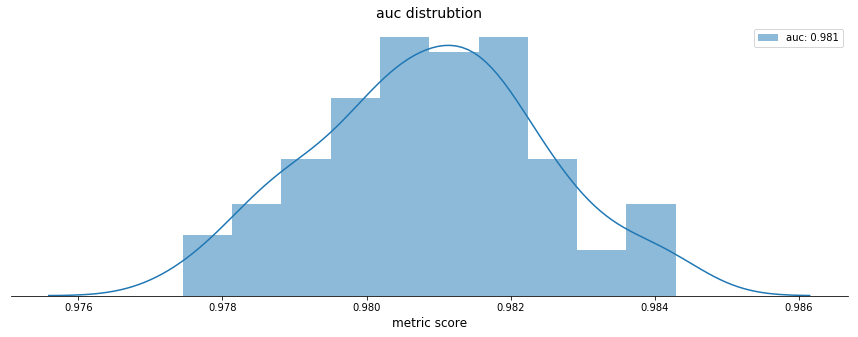

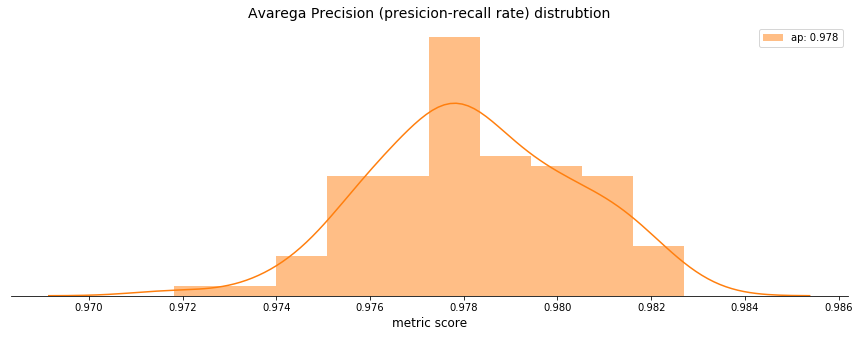

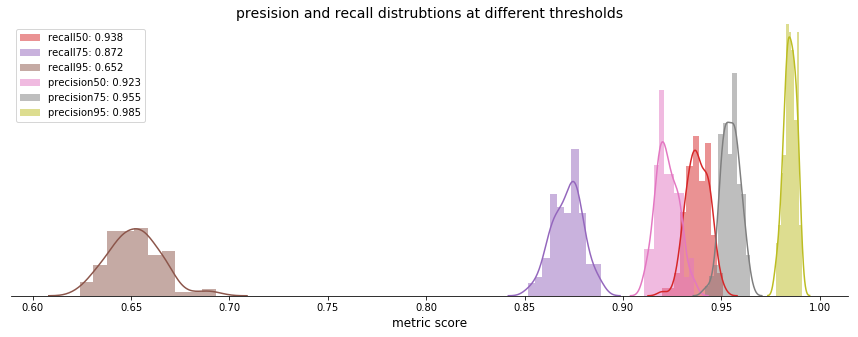

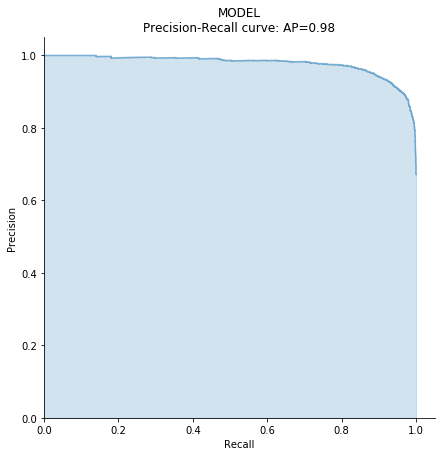

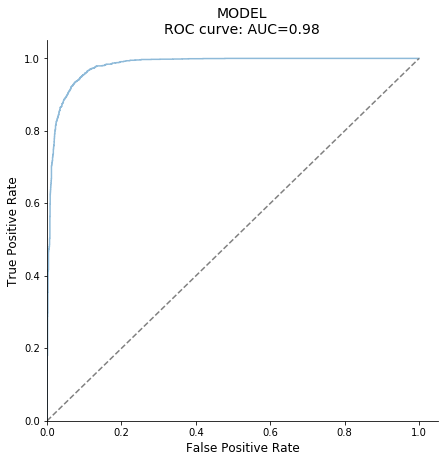

In [15]:
auc_plot(dict_of_metrics0)
ap_plot(dict_of_metrics0)
recall_precision_plot(dict_of_metrics0)

prc_plot(dict_of_metrics0)
roc_plot(dict_of_metrics0)

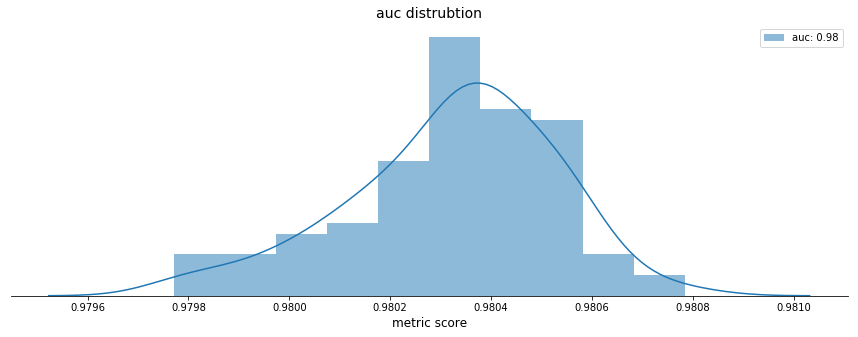

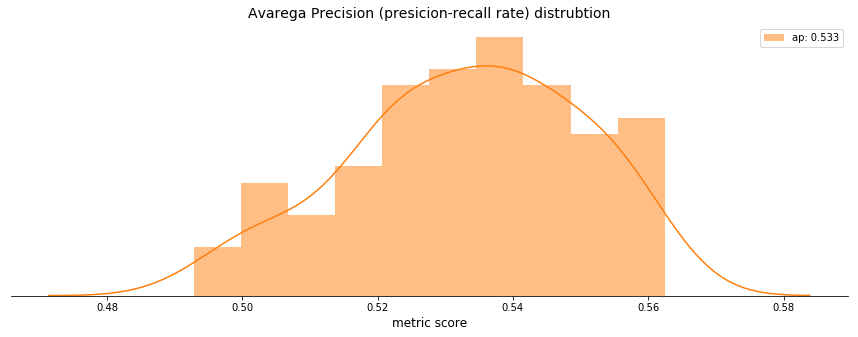

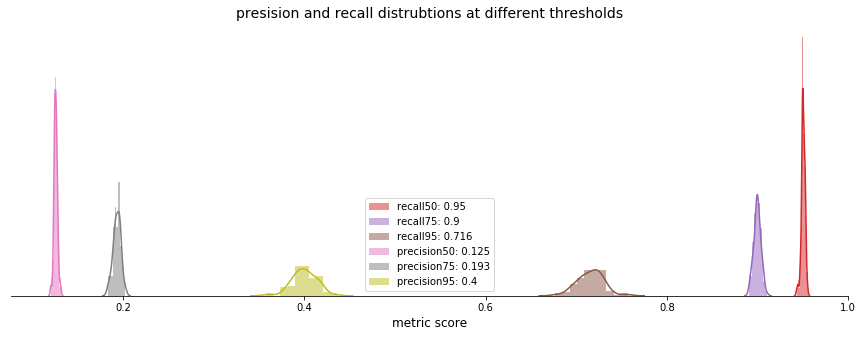

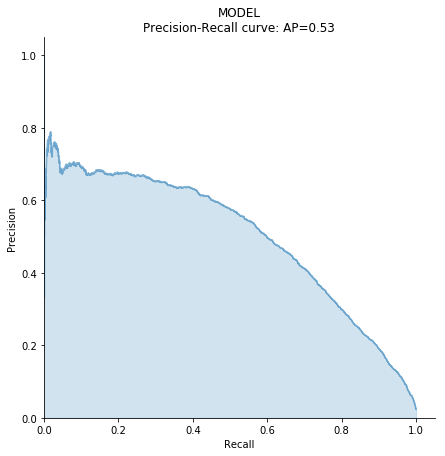

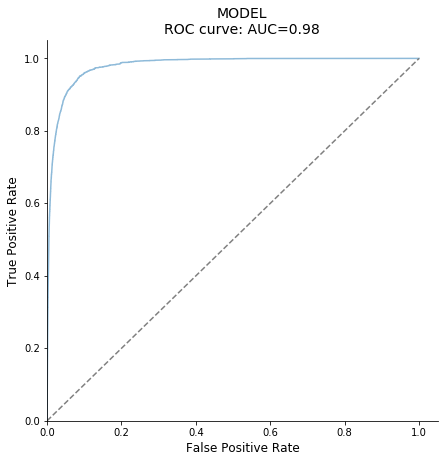

In [16]:
auc_plot(dict_of_metrics1)
ap_plot(dict_of_metrics1)
recall_precision_plot(dict_of_metrics1)

prc_plot(dict_of_metrics1)
roc_plot(dict_of_metrics1)

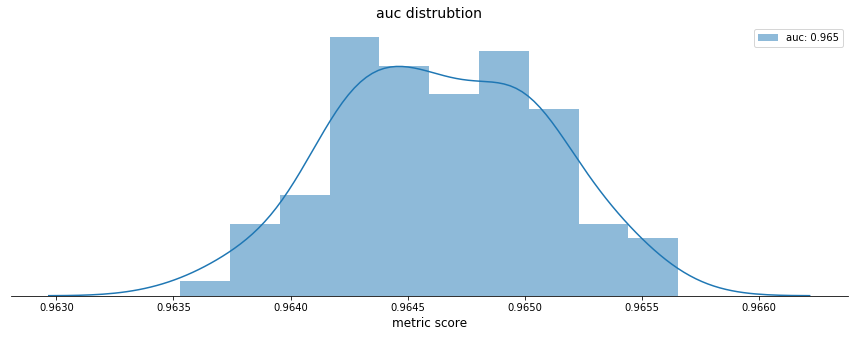

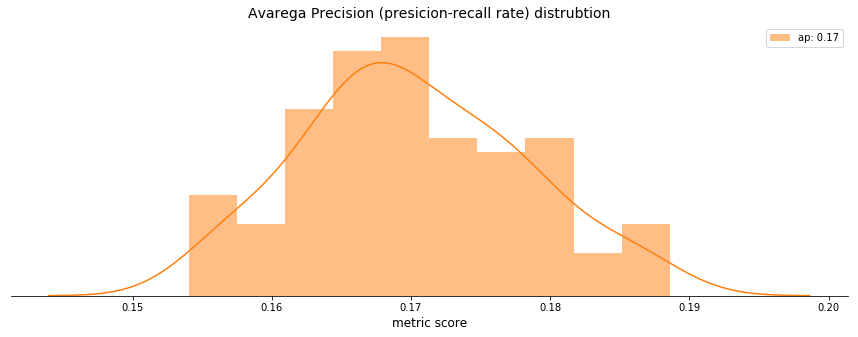

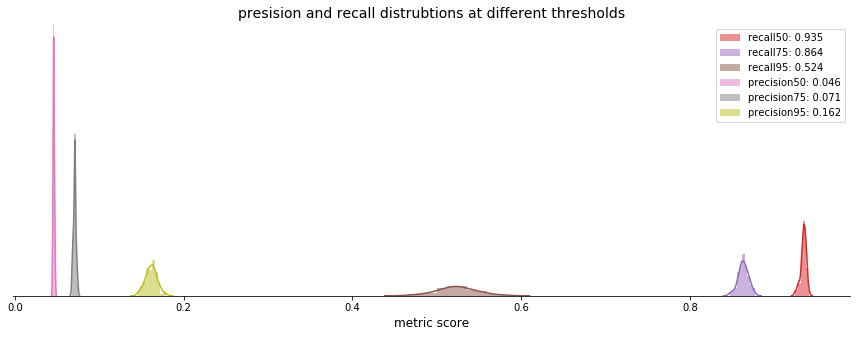

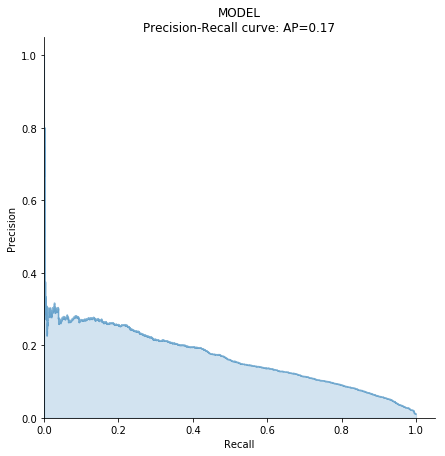

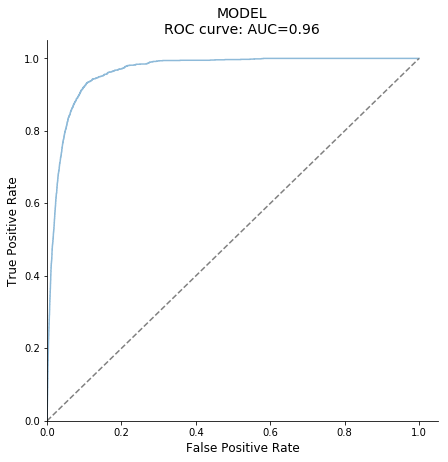

In [17]:
auc_plot(dict_of_metrics2)
ap_plot(dict_of_metrics2)
recall_precision_plot(dict_of_metrics2)

prc_plot(dict_of_metrics2)
roc_plot(dict_of_metrics2)


Now plot a map of true and predicted conflicts in 2006

# OLD:

In [19]:
dict_of_metrics = out_years_estimation(10)

0_1_2_3_4_5_6_7_8_9_

In [25]:
dict_of_metrics = out_years_estimation_onsets(10)

Number of observation/conflicts discarded: 7931
Number of observation preserved: 1288417
Number of conflicts preserved: 7225
0_1_2_3_4_5_6_7_8_9_

In [11]:
dict_of_metrics = in_years_estimation(10)

0_1_2_3_4_5_6_7_8_9_

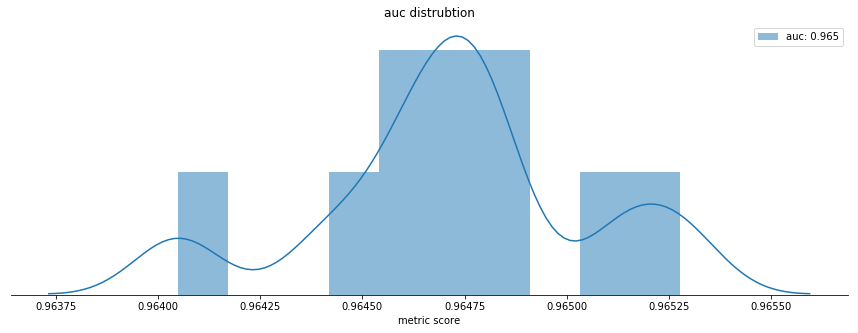

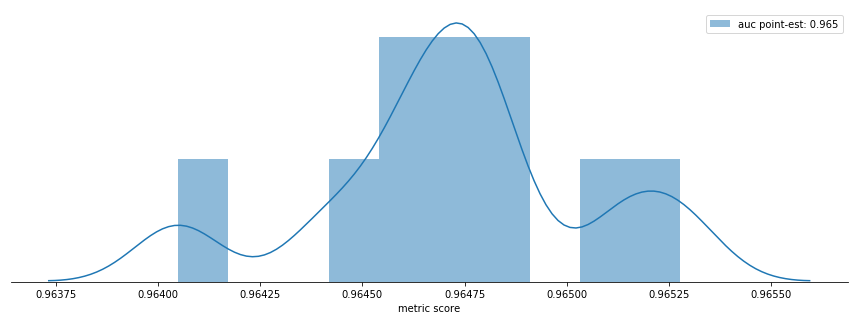

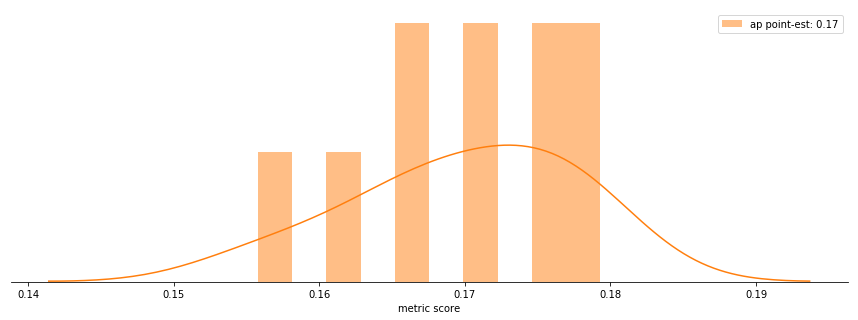

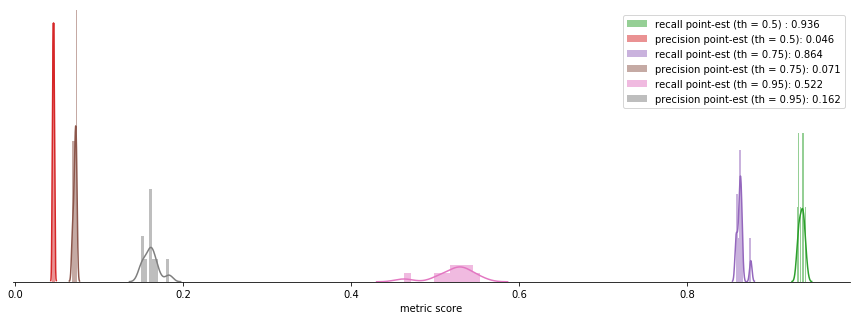

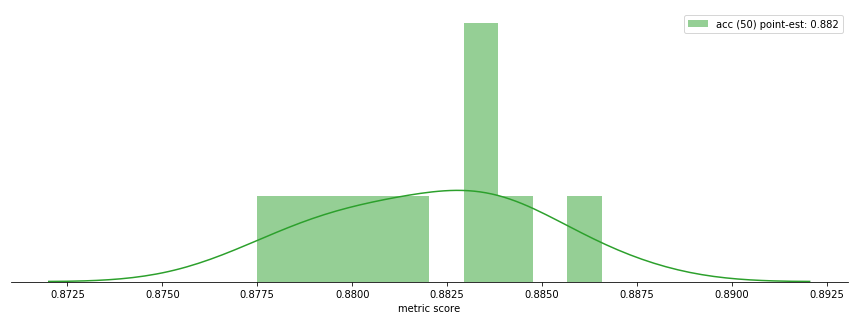

In [26]:
# 1/1
label0 = 'auc point-est: ' + str(np.mean(dict_of_metrics['auc']).round(3))
label1 = 'ap point-est: ' + str(np.mean(dict_of_metrics['ap']).round(3))

plt.figure(figsize=[15,5])

plt.hist(dict_of_metrics['auc'], density=True, label = label0, alpha = 0.5, color = 'C0')
sns.kdeplot(dict_of_metrics['auc'], color = "C0")

plt.legend()
plt.yticks([])
sns.despine(left=True)
plt.xlabel('metric score')

plt.show()


plt.figure(figsize=[15,5])

plt.hist(dict_of_metrics['ap'], density=True, label = label1, alpha = 0.5, color = 'C1')
sns.kdeplot(dict_of_metrics['ap'], color = 'C1')

plt.legend()
plt.yticks([])
sns.despine(left=True)
plt.xlabel('metric score')

plt.show()


plt.figure(figsize=[15,5])


label2_50 = 'recall point-est (th = 0.5) : ' + str(np.mean(dict_of_metrics['recall50']).round(3))
label3_50 = 'precision point-est (th = 0.5): ' + str(np.mean(dict_of_metrics['precision50']).round(3))

label2_75 = 'recall point-est (th = 0.75): ' + str(np.mean(dict_of_metrics['recall75']).round(3))
label3_75 = 'precision point-est (th = 0.75): ' + str(np.mean(dict_of_metrics['precision75']).round(3))

label2_95 = 'recall point-est (th = 0.95): ' + str(np.mean(dict_of_metrics['recall95']).round(3))
label3_95 = 'precision point-est (th = 0.95): ' + str(np.mean(dict_of_metrics['precision95']).round(3))


plt.hist(dict_of_metrics['recall50'], density=True, label = label2_50, alpha = 0.5, color = 'C2')
sns.kdeplot(dict_of_metrics['recall50'], color = 'C2')


plt.hist(dict_of_metrics['precision50'], density=True, label = label3_50, alpha = 0.5, color = 'C3')
sns.kdeplot(dict_of_metrics['precision50'], color = 'C3')

plt.hist(dict_of_metrics['recall75'], density=True, label = label2_75, alpha = 0.5, color = 'C4')
sns.kdeplot(dict_of_metrics['recall75'], color = 'C4')


plt.hist(dict_of_metrics['precision75'], density=True, label = label3_75, alpha = 0.5, color = 'C5')
sns.kdeplot(dict_of_metrics['precision75'], color = 'C5')

plt.hist(dict_of_metrics['recall95'], density=True, label = label2_95, alpha = 0.5, color = 'C6')
sns.kdeplot(dict_of_metrics['recall95'], color = 'C6')


plt.hist(dict_of_metrics['precision95'], density=True, label = label3_95, alpha = 0.5, color = 'C7')
sns.kdeplot(dict_of_metrics['precision95'], color = 'C7')



plt.legend()
plt.yticks([])
sns.despine(left=True)
plt.xlabel('metric score')

plt.show()

plt.figure(figsize=[15,5])

label_a = 'acc (50) point-est: ' + str(np.mean(dict_of_metrics['accuracy50']).round(3))

plt.hist(dict_of_metrics['accuracy50'], density=True, label = label_a, alpha = 0.5, color = 'C2')
sns.kdeplot(dict_of_metrics['accuracy50'], color = 'C2')

plt.legend()
plt.yticks([])
sns.despine(left=True)
plt.xlabel('metric score')

plt.show()
# -----------------------------------------------



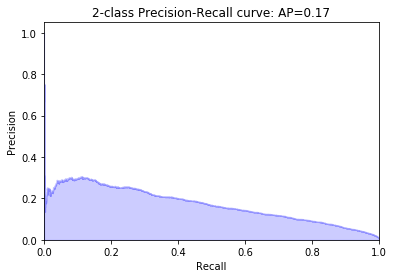

In [27]:

precision, recall, _ = dict_of_metrics['prc'][0] # but that is just the fist. You have a dist

#In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          np.mean(dict_of_metrics['ap'])))

plt.show()

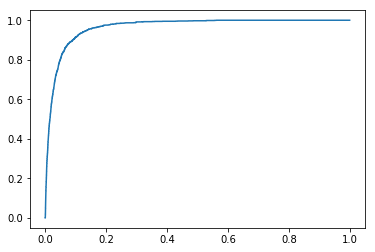

In [28]:

fpr, tpr, threshold = dict_of_metrics['roc'][0]# but that is just the fist. You have a dist

plt.plot(fpr, tpr)
plt.show()

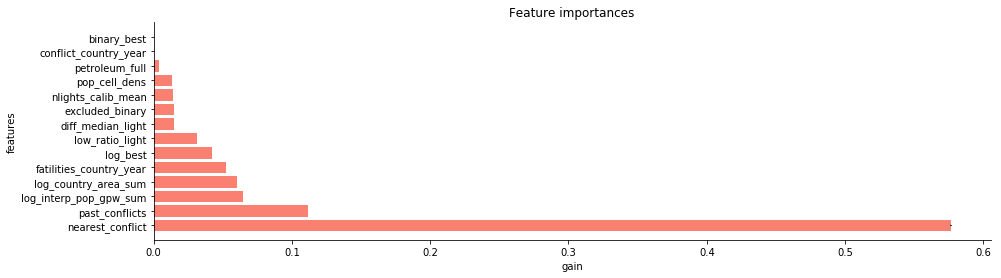

In [32]:
X_labels = ['fatilities_country_year', 'log_best', 'log_country_area_sum',
            'low_ratio_light', 'nearest_conflict', 'nlights_calib_mean',
            'past_conflicts', 'excluded_binary', 'petroleum_full',
            'diff_median_light','binary_best', 'pop_cell_dens', 
            'log_interp_pop_gpw_sum','conflict_country_year']


#importances = xg_cl.feature_importances_
importances = np.array(dict_of_metrics['feature_imp']).mean(0)
importances_std = np.array(dict_of_metrics['feature_imp']).std(0)


indices = np.argsort(importances)[::-1]

size = len(importances)

plt.figure(figsize=[15,int(size/3)])

plt.title("Feature importances")


plt.barh(range(size), importances[indices], color="salmon", align="center", yerr=importances_std[indices])

plt.yticks(range(size),  np.array(X_labels)[indices])
plt.ylim([-1, size])

plt.xlabel('gain')
plt.ylabel('features')

sns.despine()
plt.show()

# OLD Estiamtions:

## Balanced test and train:

In [67]:
# Hold out years:
df_test_years = df[df['year']>2005].copy()
df_train_years = df[df['year']<=2005].copy()

#radnom seeds for loop (culd do without, but it eases intpr.)
random_seeds = np.random.randint(1000,9999,1000)

# list of metrics
# list of metrics
dict_of_metrics = {}
dict_of_metrics['acc'] = []
dict_of_metrics['auc'] = []
dict_of_metrics['ap'] = []

dict_of_metrics['recall50'] = []
dict_of_metrics['recall75'] = []
dict_of_metrics['recall95'] = []

dict_of_metrics['precision50'] = []
dict_of_metrics['precision75'] = []
dict_of_metrics['precision95'] = []
# add more and roc + ap-curve data later on.
# And feature imp!


# feature and target labels:

X_labels = ['fatilities_country_year', 'log_best', 'log_country_area_sum',
        'low_ratio_light', 'nearest_conflict', 'nlights_calib_mean',
        'past_conflicts', 'excluded_binary', 'petroleum_full',
        'diff_median_light','binary_best', 'pop_cell_dens', 
        'log_interp_pop_gpw_sum','conflict_country_year']

y_label = 'lead_binary_best'

df_train_years_1 = df_train_years[df_train_years['lead_binary_best'] == 1] # events


#for loop
for i in range(1000):

    # The data:
    # the non_events! rigth now 1000 percent
    df_train_years_0 = df_train_years[df_train_years['lead_binary_best'] == 0].sample(df_train_years_1.shape[0], random_state = random_seeds[i])
    
    #Merge events and non-events; rigth now 10/100
    df_train_years_01 = pd.concat([df_train_years_0,df_train_years_1])
    
    # dfine X and y
    X = df_train_years_01[X_labels]

    y = df_train_years_01[y_label]
    
    # test_train: TEMP:
    # Create the training and test sets
    X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=random_seeds[i])
    
    
    # the model
    # Instantiate the XGBClassifier: xg_cl
    xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, seed=random_seeds[i])

    # Fit the classifier to the training set
    xg_cl.fit(X_train, y_train)

    # Predict the labels of the test set: preds
    preds = xg_cl.predict_proba(X_test)
    
    preds50 = (preds[:,1] >= 0.5)*1 # binary class with thresshold at 0.5 (standart)
    preds75 = (preds[:,1] >= 0.75)*1 # binary class with thresshold at 0.75 (standart)
    preds95 = (preds[:,1] >= 0.95)*1 # binary class with thresshold at 0.95 (standart)
    
    dict_of_metrics['ap'].append(average_precision_score(y_test,preds[:,1]))
    dict_of_metrics['auc'].append(roc_auc_score(y_test,preds[:,1]))
    
    dict_of_metrics['recall50'].append(recall_score(y_test, preds50))
    dict_of_metrics['recall75'].append(recall_score(y_test, preds75))
    dict_of_metrics['recall95'].append(recall_score(y_test, preds95))

    dict_of_metrics['precision50'].append(precision_score(y_test, preds50))
    dict_of_metrics['precision75'].append(precision_score(y_test, preds75))
    dict_of_metrics['precision95'].append(precision_score(y_test, preds95))

    
    print(i, end='_')
    

0_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15_16_17_18_19_20_21_22_23_24_25_26_27_28_29_30_31_32_33_34_35_36_37_38_39_40_41_42_43_44_45_46_47_48_49_50_51_52_53_54_55_56_57_58_59_60_61_62_63_64_65_66_67_68_69_70_71_72_73_74_75_76_77_78_79_80_81_82_83_84_85_86_87_88_89_90_91_92_93_94_95_96_97_98_99_100_101_102_103_104_105_106_107_108_109_110_111_112_113_114_115_116_117_118_119_120_121_122_123_124_125_126_127_128_129_130_131_132_133_134_135_136_137_138_139_140_141_142_143_144_145_146_147_148_149_150_151_152_153_154_155_156_157_158_159_160_161_162_163_164_165_166_167_168_169_170_171_172_173_174_175_176_177_178_179_180_181_182_183_184_185_186_187_188_189_190_191_192_193_194_195_196_197_198_199_200_201_202_203_204_205_206_207_208_209_210_211_212_213_214_215_216_217_218_219_220_221_222_223_224_225_226_227_228_229_230_231_232_233_234_235_236_237_238_239_240_241_242_243_244_245_246_247_248_249_250_251_252_253_254_255_256_257_258_259_260_261_262_263_264_265_266_267_268_269_270_271_272_273_274_275_276_27

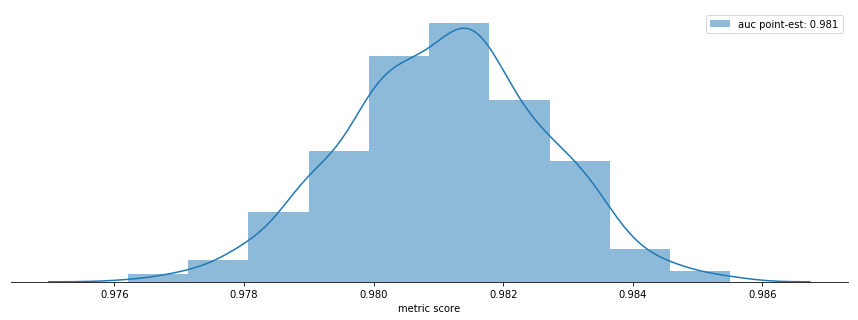

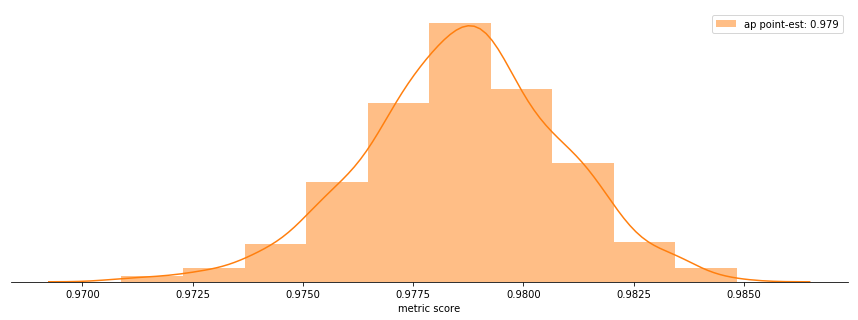

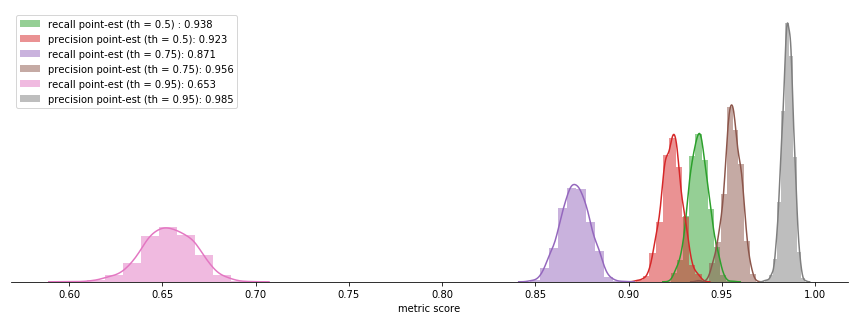

In [68]:
# 1/1
label0 = 'auc point-est: ' + str(np.mean(dict_of_metrics['auc']).round(3))
label1 = 'ap point-est: ' + str(np.mean(dict_of_metrics['ap']).round(3))

plt.figure(figsize=[15,5])

plt.hist(dict_of_metrics['auc'], density=True, label = label0, alpha = 0.5, color = 'C0')
sns.kdeplot(dict_of_metrics['auc'], color = "C0")

plt.legend()
plt.yticks([])
sns.despine(left=True)
plt.xlabel('metric score')

plt.show()


plt.figure(figsize=[15,5])

plt.hist(dict_of_metrics['ap'], density=True, label = label1, alpha = 0.5, color = 'C1')
sns.kdeplot(dict_of_metrics['ap'], color = 'C1')

plt.legend()
plt.yticks([])
sns.despine(left=True)
plt.xlabel('metric score')

plt.show()


plt.figure(figsize=[15,5])


label2_50 = 'recall point-est (th = 0.5) : ' + str(np.mean(dict_of_metrics['recall50']).round(3))
label3_50 = 'precision point-est (th = 0.5): ' + str(np.mean(dict_of_metrics['precision50']).round(3))

label2_75 = 'recall point-est (th = 0.75): ' + str(np.mean(dict_of_metrics['recall75']).round(3))
label3_75 = 'precision point-est (th = 0.75): ' + str(np.mean(dict_of_metrics['precision75']).round(3))

label2_95 = 'recall point-est (th = 0.95): ' + str(np.mean(dict_of_metrics['recall95']).round(3))
label3_95 = 'precision point-est (th = 0.95): ' + str(np.mean(dict_of_metrics['precision95']).round(3))


plt.hist(dict_of_metrics['recall50'], density=True, label = label2_50, alpha = 0.5, color = 'C2')
sns.kdeplot(dict_of_metrics['recall50'], color = 'C2')


plt.hist(dict_of_metrics['precision50'], density=True, label = label3_50, alpha = 0.5, color = 'C3')
sns.kdeplot(dict_of_metrics['precision50'], color = 'C3')

plt.hist(dict_of_metrics['recall75'], density=True, label = label2_75, alpha = 0.5, color = 'C4')
sns.kdeplot(dict_of_metrics['recall75'], color = 'C4')


plt.hist(dict_of_metrics['precision75'], density=True, label = label3_75, alpha = 0.5, color = 'C5')
sns.kdeplot(dict_of_metrics['precision75'], color = 'C5')

plt.hist(dict_of_metrics['recall95'], density=True, label = label2_95, alpha = 0.5, color = 'C6')
sns.kdeplot(dict_of_metrics['recall95'], color = 'C6')


plt.hist(dict_of_metrics['precision95'], density=True, label = label3_95, alpha = 0.5, color = 'C7')
sns.kdeplot(dict_of_metrics['precision95'], color = 'C7')



plt.legend()
plt.yticks([])
sns.despine(left=True)
plt.xlabel('metric score')

plt.show()

# unbalcend test set (hold-out years):
balanced model:

In [76]:
# Hold out years:
df_test_years = df[df['year']>2005].copy()
df_train_years = df[df['year']<=2005].copy()

#radnom seeds for loop (culd do without, but it eases intpr.)
random_seeds = np.random.randint(1000,9999,1000)

# list of metrics
dict_of_metrics = {}
dict_of_metrics['auc'] = []
dict_of_metrics['ap'] = []

dict_of_metrics['recall50'] = []
dict_of_metrics['recall75'] = []
dict_of_metrics['recall95'] = []

dict_of_metrics['precision50'] = []
dict_of_metrics['precision75'] = []
dict_of_metrics['precision95'] = []

# add more and roc + ap-curve data later on.
# And feature imp!


# feature and target labels:

X_labels = ['fatilities_country_year', 'log_best', 'log_country_area_sum',
        'low_ratio_light', 'nearest_conflict', 'nlights_calib_mean',
        'past_conflicts', 'excluded_binary', 'petroleum_full',
        'diff_median_light','binary_best', 'pop_cell_dens', 
        'log_interp_pop_gpw_sum','conflict_country_year']

y_label = 'lead_binary_best'

df_train_years_1 = df_train_years[df_train_years['lead_binary_best'] == 1] # events


#for loop
for i in range(100):

    # The data:
    # the non_events! rigth now 1000 percent
    df_train_years_0 = df_train_years[df_train_years['lead_binary_best'] == 0].sample(df_train_years_1.shape[0]*3, random_state = random_seeds[i]) 
    # you shoul dmeak one with *1 and *20 manke it an input in the function 
    
    #Merge events and non-events; rigth now 10/100
    df_train_years_01 = pd.concat([df_train_years_0,df_train_years_1])
    
    # dfine X and y
    X_train = df_train_years_01[X_labels]

    y_train = df_train_years_01[y_label]
    
    # test_train: TEMP:
    # Create the training and test sets
    #X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=random_seeds[i])
    
    X_test = df_test_years[X_labels]
    y_test = df_test_years[y_label]
    
    # the model
    # Instantiate the XGBClassifier: xg_cl
    xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, seed=random_seeds[i])

    # Fit the classifier to the training set
    xg_cl.fit(X_train, y_train)

    # Predict the labels of the test set: preds
    preds = xg_cl.predict_proba(X_test)
    
    preds50 = (preds[:,1] >= 0.5)*1 # binary class with thresshold at 0.5 (standart)
    preds75 = (preds[:,1] >= 0.75)*1 # binary class with thresshold at 0.75 (standart)
    preds95 = (preds[:,1] >= 0.95)*1 # binary class with thresshold at 0.95 (standart)
    
    dict_of_metrics['ap'].append(average_precision_score(y_test,preds[:,1]))
    dict_of_metrics['auc'].append(roc_auc_score(y_test,preds[:,1]))
    
    dict_of_metrics['recall50'].append(recall_score(y_test, preds50))
    dict_of_metrics['recall75'].append(recall_score(y_test, preds75))
    dict_of_metrics['recall95'].append(recall_score(y_test, preds95))

    dict_of_metrics['precision50'].append(precision_score(y_test, preds50))
    dict_of_metrics['precision75'].append(precision_score(y_test, preds75))
    dict_of_metrics['precision95'].append(precision_score(y_test, preds95))

    
    print(i, end='_')
    

0_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15_16_17_18_19_20_21_22_23_24_25_26_27_28_29_30_31_32_33_34_35_36_37_38_39_40_41_42_43_44_45_46_47_48_49_50_51_52_53_54_55_56_57_58_59_60_61_62_63_64_65_66_67_68_69_70_71_72_73_74_75_76_77_78_79_80_81_82_83_84_85_86_87_88_89_90_91_92_93_94_95_96_97_98_99_

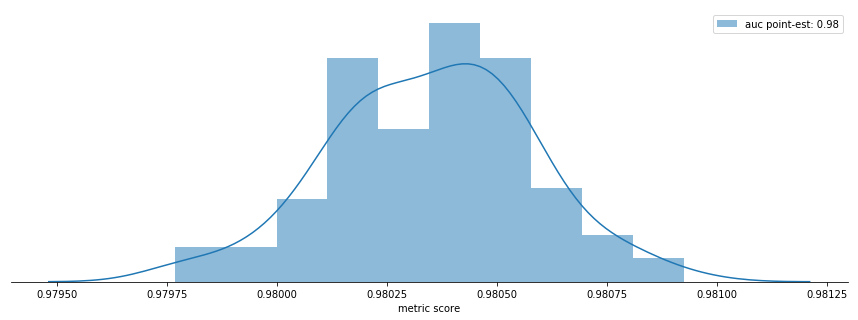

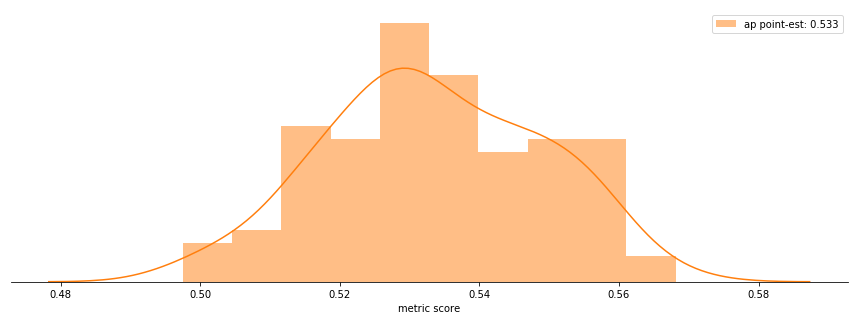

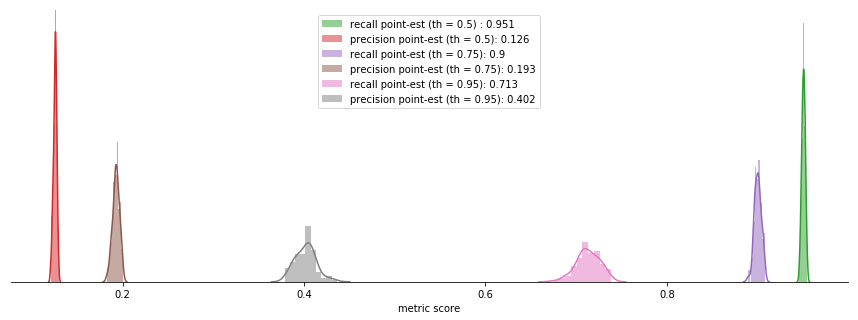

In [73]:
# 1/1
label0 = 'auc point-est: ' + str(np.mean(dict_of_metrics['auc']).round(3))
label1 = 'ap point-est: ' + str(np.mean(dict_of_metrics['ap']).round(3))

plt.figure(figsize=[15,5])

plt.hist(dict_of_metrics['auc'], density=True, label = label0, alpha = 0.5, color = 'C0')
sns.kdeplot(dict_of_metrics['auc'], color = "C0")

plt.legend()
plt.yticks([])
sns.despine(left=True)
plt.xlabel('metric score')

plt.show()


plt.figure(figsize=[15,5])

plt.hist(dict_of_metrics['ap'], density=True, label = label1, alpha = 0.5, color = 'C1')
sns.kdeplot(dict_of_metrics['ap'], color = 'C1')

plt.legend()
plt.yticks([])
sns.despine(left=True)
plt.xlabel('metric score')

plt.show()


plt.figure(figsize=[15,5])


label2_50 = 'recall point-est (th = 0.5) : ' + str(np.mean(dict_of_metrics['recall50']).round(3))
label3_50 = 'precision point-est (th = 0.5): ' + str(np.mean(dict_of_metrics['precision50']).round(3))

label2_75 = 'recall point-est (th = 0.75): ' + str(np.mean(dict_of_metrics['recall75']).round(3))
label3_75 = 'precision point-est (th = 0.75): ' + str(np.mean(dict_of_metrics['precision75']).round(3))

label2_95 = 'recall point-est (th = 0.95): ' + str(np.mean(dict_of_metrics['recall95']).round(3))
label3_95 = 'precision point-est (th = 0.95): ' + str(np.mean(dict_of_metrics['precision95']).round(3))


plt.hist(dict_of_metrics['recall50'], density=True, label = label2_50, alpha = 0.5, color = 'C2')
sns.kdeplot(dict_of_metrics['recall50'], color = 'C2')


plt.hist(dict_of_metrics['precision50'], density=True, label = label3_50, alpha = 0.5, color = 'C3')
sns.kdeplot(dict_of_metrics['precision50'], color = 'C3')

plt.hist(dict_of_metrics['recall75'], density=True, label = label2_75, alpha = 0.5, color = 'C4')
sns.kdeplot(dict_of_metrics['recall75'], color = 'C4')


plt.hist(dict_of_metrics['precision75'], density=True, label = label3_75, alpha = 0.5, color = 'C5')
sns.kdeplot(dict_of_metrics['precision75'], color = 'C5')

plt.hist(dict_of_metrics['recall95'], density=True, label = label2_95, alpha = 0.5, color = 'C6')
sns.kdeplot(dict_of_metrics['recall95'], color = 'C6')


plt.hist(dict_of_metrics['precision95'], density=True, label = label3_95, alpha = 0.5, color = 'C7')
sns.kdeplot(dict_of_metrics['precision95'], color = 'C7')



plt.legend()
plt.yticks([])
sns.despine(left=True)
plt.xlabel('metric score')

plt.show()

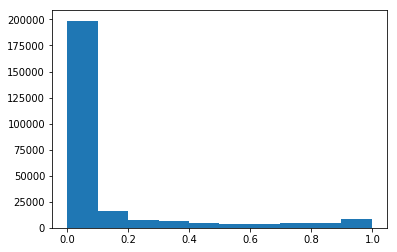

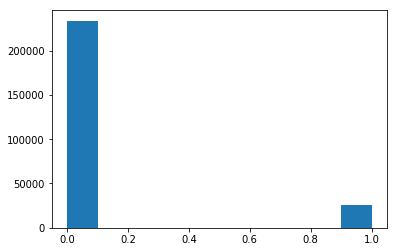

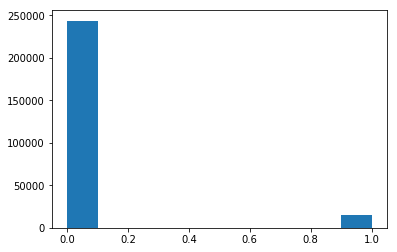

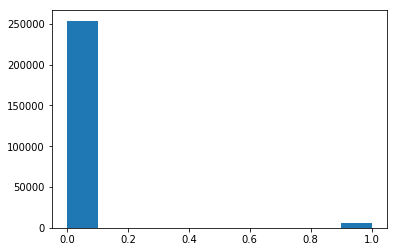

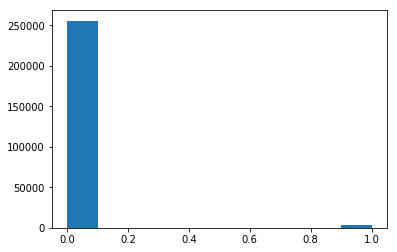

In [75]:
plt.hist(preds[:,1])
plt.show()

plt.hist((preds[:,1] > 0.50)*1)
plt.show()

plt.hist((preds[:,1] > 0.75)*1)
plt.show()


plt.hist((preds[:,1] > 0.95)*1)
plt.show()

plt.hist(y_test)
plt.show()


# unbalcend test set (hold-out years):
unbalanced model:

In [69]:
# Hold out years:
df_test_years = df[df['year']>2005].copy()
df_train_years = df[df['year']<=2005].copy()

#radnom seeds for loop (culd do without, but it eases intpr.)
random_seeds = np.random.randint(1000,9999,1000)

# list of metrics
dict_of_metrics = {}
dict_of_metrics['auc'] = []
dict_of_metrics['ap'] = []

dict_of_metrics['recall50'] = []
dict_of_metrics['recall75'] = []
dict_of_metrics['recall95'] = []

dict_of_metrics['precision50'] = []
dict_of_metrics['precision75'] = []
dict_of_metrics['precision95'] = []

# add more and roc + ap-curve data later on.
# And feature imp!


# feature and target labels:

X_labels = ['fatilities_country_year', 'log_best', 'log_country_area_sum',
        'low_ratio_light', 'nearest_conflict', 'nlights_calib_mean',
        'past_conflicts', 'excluded_binary', 'petroleum_full',
        'diff_median_light','binary_best', 'pop_cell_dens', 
        'log_interp_pop_gpw_sum','conflict_country_year']

y_label = 'lead_binary_best'

df_train_years_1 = df_train_years[df_train_years['lead_binary_best'] == 1] # events


#for loop
for i in range(1000):

    # The data:
    # the non_events! rigth now 1000 percent
    df_train_years_0 = df_train_years[df_train_years['lead_binary_best'] == 0].sample(df_train_years_1.shape[0]*20, random_state = random_seeds[i]) 
    # you shoul dmeak one with *1 and *20 manke it an input in the function 
    
    #Merge events and non-events; rigth now 10/100
    df_train_years_01 = pd.concat([df_train_years_0,df_train_years_1])
    
    # dfine X and y
    X_train = df_train_years_01[X_labels]

    y_train = df_train_years_01[y_label]
    
    # test_train: TEMP:
    # Create the training and test sets
    #X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=random_seeds[i])
    
    X_test = df_test_years[X_labels]
    y_test = df_test_years[y_label]
    
    # the model
    # Instantiate the XGBClassifier: xg_cl
    xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, seed=random_seeds[i])

    # Fit the classifier to the training set
    xg_cl.fit(X_train, y_train)

    # Predict the labels of the test set: preds
    preds = xg_cl.predict_proba(X_test)
    
    preds50 = (preds[:,1] >= 0.5)*1 # binary class with thresshold at 0.5 (standart)
    preds75 = (preds[:,1] >= 0.75)*1 # binary class with thresshold at 0.75 (standart)
    preds95 = (preds[:,1] >= 0.95)*1 # binary class with thresshold at 0.95 (standart)
    
    dict_of_metrics['ap'].append(average_precision_score(y_test,preds[:,1]))
    dict_of_metrics['auc'].append(roc_auc_score(y_test,preds[:,1]))
    
    dict_of_metrics['recall50'].append(recall_score(y_test, preds50))
    dict_of_metrics['recall75'].append(recall_score(y_test, preds75))
    dict_of_metrics['recall95'].append(recall_score(y_test, preds95))

    dict_of_metrics['precision50'].append(precision_score(y_test, preds50))
    dict_of_metrics['precision75'].append(precision_score(y_test, preds75))
    dict_of_metrics['precision95'].append(precision_score(y_test, preds95))

    
    print(i, end='_')
    

0_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15_16_17_18_19_20_21_22_23_24_25_26_27_28_29_30_31_32_33_34_35_36_37_38_39_40_41_42_43_44_45_46_47_48_49_50_51_52_53_54_55_56_57_58_59_60_61_62_63_64_65_66_67_68_69_70_71_72_73_74_75_76_77_78_79_80_81_82_83_84_85_86_87_88_89_90_91_92_93_94_95_96_97_98_99_100_101_102_103_104_105_106_107_108_109_110_111_112_113_114_115_116_117_118_119_120_121_122_123_124_125_126_127_128_129_130_131_132_133_134_135_136_137_138_139_140_141_142_143_144_145_146_147_148_149_150_151_152_153_154_155_156_157_158_159_160_161_162_163_164_165_166_167_168_169_170_171_172_173_174_175_176_177_178_179_180_181_182_183_184_185_186_187_188_189_190_191_192_193_194_195_196_197_198_199_200_201_202_203_204_205_206_207_208_209_210_211_212_213_214_215_216_217_218_219_220_221_222_223_224_225_226_227_228_229_230_231_232_233_234_235_236_237_238_239_240_241_242_243_244_245_246_247_248_249_250_251_252_253_254_255_256_257_258_259_260_261_262_263_264_265_266_267_268_269_270_271_272_273_274_275_276_27

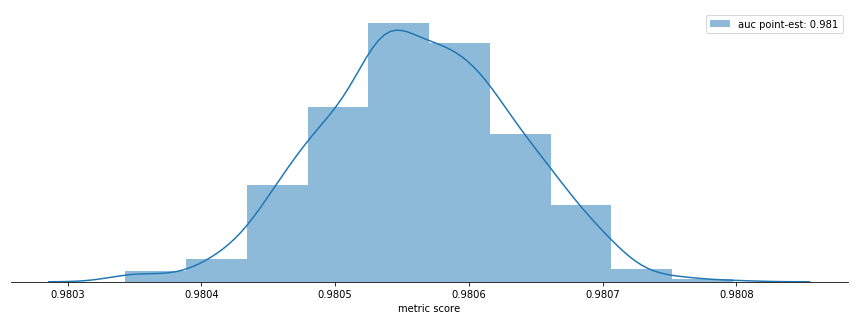

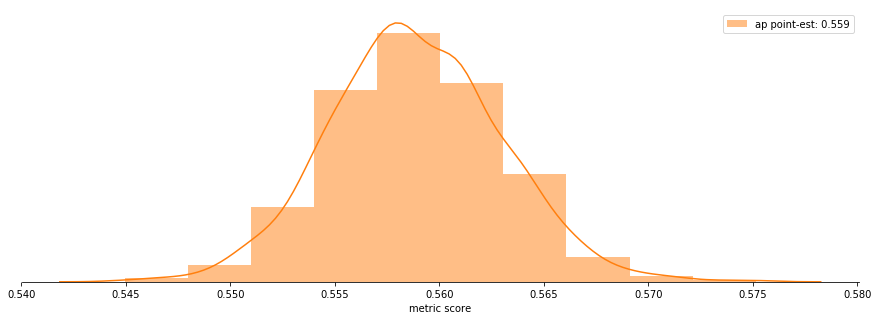

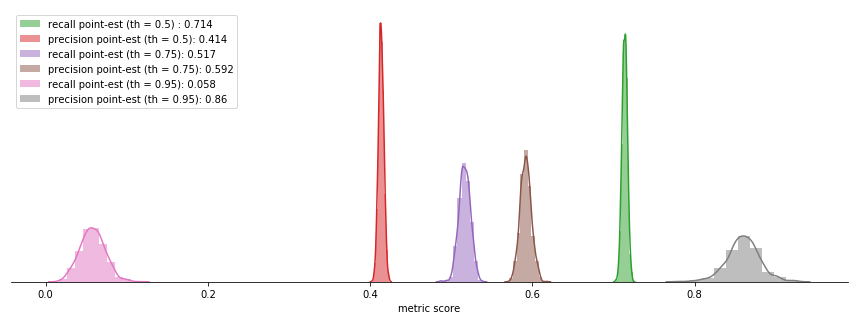

In [70]:
# 1/1
label0 = 'auc point-est: ' + str(np.mean(dict_of_metrics['auc']).round(3))
label1 = 'ap point-est: ' + str(np.mean(dict_of_metrics['ap']).round(3))

plt.figure(figsize=[15,5])

plt.hist(dict_of_metrics['auc'], density=True, label = label0, alpha = 0.5, color = 'C0')
sns.kdeplot(dict_of_metrics['auc'], color = "C0")

plt.legend()
plt.yticks([])
sns.despine(left=True)
plt.xlabel('metric score')

plt.show()


plt.figure(figsize=[15,5])

plt.hist(dict_of_metrics['ap'], density=True, label = label1, alpha = 0.5, color = 'C1')
sns.kdeplot(dict_of_metrics['ap'], color = 'C1')

plt.legend()
plt.yticks([])
sns.despine(left=True)
plt.xlabel('metric score')

plt.show()


plt.figure(figsize=[15,5])


label2_50 = 'recall point-est (th = 0.5) : ' + str(np.mean(dict_of_metrics['recall50']).round(3))
label3_50 = 'precision point-est (th = 0.5): ' + str(np.mean(dict_of_metrics['precision50']).round(3))

label2_75 = 'recall point-est (th = 0.75): ' + str(np.mean(dict_of_metrics['recall75']).round(3))
label3_75 = 'precision point-est (th = 0.75): ' + str(np.mean(dict_of_metrics['precision75']).round(3))

label2_95 = 'recall point-est (th = 0.95): ' + str(np.mean(dict_of_metrics['recall95']).round(3))
label3_95 = 'precision point-est (th = 0.95): ' + str(np.mean(dict_of_metrics['precision95']).round(3))


plt.hist(dict_of_metrics['recall50'], density=True, label = label2_50, alpha = 0.5, color = 'C2')
sns.kdeplot(dict_of_metrics['recall50'], color = 'C2')


plt.hist(dict_of_metrics['precision50'], density=True, label = label3_50, alpha = 0.5, color = 'C3')
sns.kdeplot(dict_of_metrics['precision50'], color = 'C3')

plt.hist(dict_of_metrics['recall75'], density=True, label = label2_75, alpha = 0.5, color = 'C4')
sns.kdeplot(dict_of_metrics['recall75'], color = 'C4')


plt.hist(dict_of_metrics['precision75'], density=True, label = label3_75, alpha = 0.5, color = 'C5')
sns.kdeplot(dict_of_metrics['precision75'], color = 'C5')

plt.hist(dict_of_metrics['recall95'], density=True, label = label2_95, alpha = 0.5, color = 'C6')
sns.kdeplot(dict_of_metrics['recall95'], color = 'C6')


plt.hist(dict_of_metrics['precision95'], density=True, label = label3_95, alpha = 0.5, color = 'C7')
sns.kdeplot(dict_of_metrics['precision95'], color = 'C7')



plt.legend()
plt.yticks([])
sns.despine(left=True)
plt.xlabel('metric score')

plt.show()

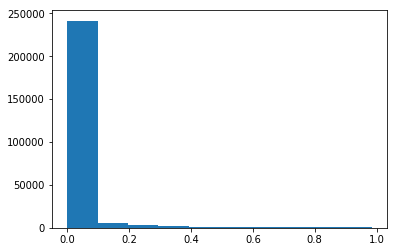

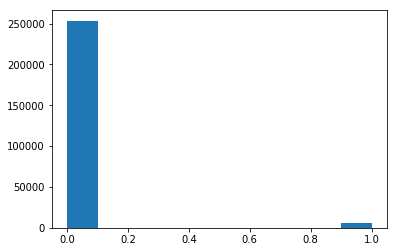

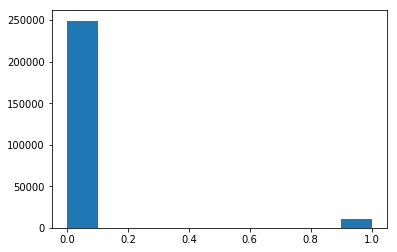

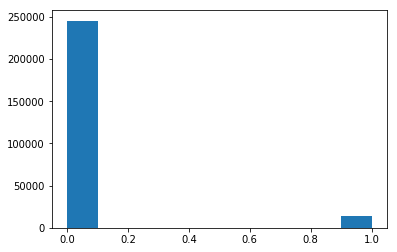

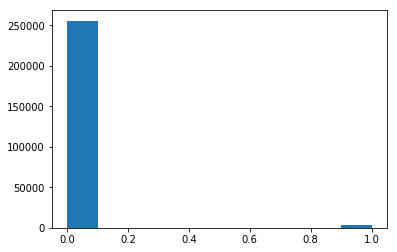

In [71]:
plt.hist(preds[:,1])
plt.show()

plt.hist((preds[:,1] > 0.50)*1)
plt.show()

plt.hist((preds[:,1] > 0.25)*1)
plt.show()


plt.hist((preds[:,1] > 0.15)*1)
plt.show()

plt.hist(y_test)
plt.show()


# to revisit:

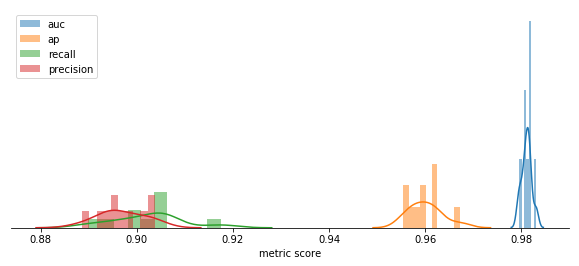

In [258]:
plt.figure(figsize=[10,4])

plt.hist(dict_of_metrics['auc'], density=True, label = 'auc', alpha = 0.5, color = 'C0')
sns.kdeplot(dict_of_metrics['auc'], color = "C0")

plt.hist(dict_of_metrics['ap'], density=True, label = 'ap', alpha = 0.5, color = 'C1')
sns.kdeplot(dict_of_metrics['ap'], color = 'C1')


plt.hist(dict_of_metrics['recall'], density=True, label = 'recall', alpha = 0.5, color = 'C2')
sns.kdeplot(dict_of_metrics['recall'], color = 'C2')


plt.hist(dict_of_metrics['precision'], density=True, label = 'precision', alpha = 0.5, color = 'C3')
sns.kdeplot(dict_of_metrics['precision'], color = 'C3')

plt.legend()
plt.yticks([])
sns.despine(left=True)
plt.xlabel('metric score')

plt.show()

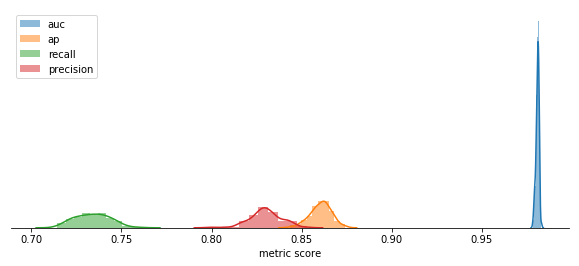

In [254]:
plt.figure(figsize=[10,4])

plt.hist(dict_of_metrics['auc'], density=True, label = 'auc', alpha = 0.5, color = 'C0')
sns.kdeplot(dict_of_metrics['auc'], color = "C0")

plt.hist(dict_of_metrics['ap'], density=True, label = 'ap', alpha = 0.5, color = 'C1')
sns.kdeplot(dict_of_metrics['ap'], color = 'C1')


plt.hist(dict_of_metrics['recall'], density=True, label = 'recall', alpha = 0.5, color = 'C2')
sns.kdeplot(dict_of_metrics['recall'], color = 'C2')


plt.hist(dict_of_metrics['precision'], density=True, label = 'precision', alpha = 0.5, color = 'C3')
sns.kdeplot(dict_of_metrics['precision'], color = 'C3')

plt.legend()
plt.yticks([])
sns.despine(left=True)
plt.xlabel('metric score')

plt.show()

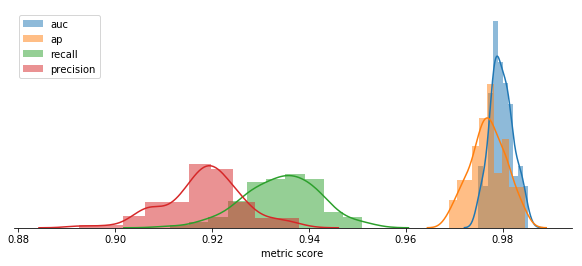

In [238]:
plt.figure(figsize=[10,4])

plt.hist(dict_of_metrics['auc'], density=True, label = 'auc', alpha = 0.5, color = 'C0')
sns.kdeplot(dict_of_metrics['auc'], color = "C0")

plt.hist(dict_of_metrics['ap'], density=True, label = 'ap', alpha = 0.5, color = 'C1')
sns.kdeplot(dict_of_metrics['ap'], color = 'C1')


plt.hist(dict_of_metrics['recall'], density=True, label = 'recall', alpha = 0.5, color = 'C2')
sns.kdeplot(dict_of_metrics['recall'], color = 'C2')


plt.hist(dict_of_metrics['precision'], density=True, label = 'precision', alpha = 0.5, color = 'C3')
sns.kdeplot(dict_of_metrics['precision'], color = 'C3')

plt.legend()
plt.yticks([])
sns.despine(left=True)
plt.xlabel('metric score')

plt.show()

## test out of year; only balanced train

In [255]:
random_seeds = np.random.randint(1000,9999,1000)

# list of metrics
# in a dict?

dict_of_metrics = {}
dict_of_metrics['auc'] = []
dict_of_metrics['recall'] = []
dict_of_metrics['ap'] = []
dict_of_metrics['precision'] = []
# add more and roc + ap-curve data later on.
# And feature imp!

X_names = ['fatilities_country_year', 'log_best', 'log_country_area_sum',
        'low_ratio_light', 'nearest_conflict', 'nlights_calib_mean',
        'past_conflicts', 'excluded_binary', 'petroleum_full',
        'diff_median_light','binary_best', 'pop_cell_dens', 
        'log_interp_pop_gpw_sum','conflict_country_year']

y_name = 'lead_binary_best'

df_test = df[df['year']>2005].copy()
df_train_full = df[df['year']<=2005].copy()

X_test = df_test[X_names]
y_test = df_test[y_name]

df_train_1 = df_train_full[df_train_full['lead_binary_best'] == 1] # events


#for loop
for i in range(100):

    # The data:
    # the non_events! rigth now 100 percent
    df_train_0 = df_train_full[df_train_full['lead_binary_best'] == 0].sample(df_train_1.shape[0]*10, random_state = random_seeds[i])
    
    #Merge events and non-events; rigth now 50/50
    df_loop = pd.concat([df_train_0,df_train_1])
    
    # dfine X and y
    X_train = df_loop[X_names]

    y_train = df_loop[y_name]
    
    # test_train: TEMP:
    # Create the training and test sets
    #X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=random_seeds[i])
    
    
    # the model
    # Instantiate the XGBClassifier: xg_cl
    xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, seed=123)

    # Fit the classifier to the training set
    xg_cl.fit(X_train, y_train)

    # Predict the labels of the test set: preds
    preds = xg_cl.predict_proba(X_test)
    
    preds050 = (preds[:,1] >= 0.5)*1 # binary class with thresshold at 0.5 (standart)
    
    dict_of_metrics['ap'].append(average_precision_score(y_test,preds[:,1]))
    dict_of_metrics['auc'].append(roc_auc_score(y_test,preds[:,1]))
    dict_of_metrics['recall'].append(recall_score(y_test, preds050))
    dict_of_metrics['precision'].append(precision_score(y_test, preds050))
    
    print(i, end='_')

0_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15_16_17_18_19_20_21_22_23_24_25_26_27_28_29_30_31_32_33_34_35_36_37_38_39_40_41_42_43_44_45_46_47_48_49_50_51_52_53_54_55_56_57_58_59_60_61_62_63_64_65_66_67_68_69_70_71_72_73_74_75_76_77_78_79_80_81_82_83_84_85_86_87_88_89_90_91_92_93_94_95_96_97_98_99_

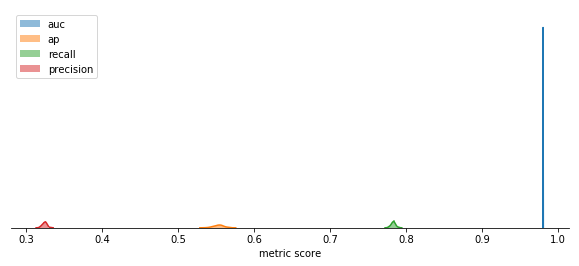

In [256]:
plt.figure(figsize=[10,4])

plt.hist(dict_of_metrics['auc'], density=True, label = 'auc', alpha = 0.5, color = 'C0')
sns.kdeplot(dict_of_metrics['auc'], color = "C0")

plt.hist(dict_of_metrics['ap'], density=True, label = 'ap', alpha = 0.5, color = 'C1')
sns.kdeplot(dict_of_metrics['ap'], color = 'C1')


plt.hist(dict_of_metrics['recall'], density=True, label = 'recall', alpha = 0.5, color = 'C2')
sns.kdeplot(dict_of_metrics['recall'], color = 'C2')


plt.hist(dict_of_metrics['precision'], density=True, label = 'precision', alpha = 0.5, color = 'C3')
sns.kdeplot(dict_of_metrics['precision'], color = 'C3')

plt.legend()
plt.yticks([])
sns.despine(left=True)
plt.xlabel('metric score')

plt.show()

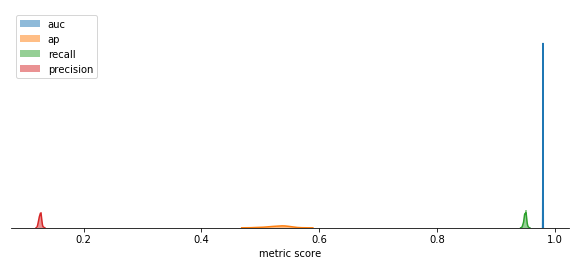

In [251]:
plt.figure(figsize=[10,4])

plt.hist(dict_of_metrics['auc'], density=True, label = 'auc', alpha = 0.5, color = 'C0')
sns.kdeplot(dict_of_metrics['auc'], color = "C0")

plt.hist(dict_of_metrics['ap'], density=True, label = 'ap', alpha = 0.5, color = 'C1')
sns.kdeplot(dict_of_metrics['ap'], color = 'C1')


plt.hist(dict_of_metrics['recall'], density=True, label = 'recall', alpha = 0.5, color = 'C2')
sns.kdeplot(dict_of_metrics['recall'], color = 'C2')


plt.hist(dict_of_metrics['precision'], density=True, label = 'precision', alpha = 0.5, color = 'C3')
sns.kdeplot(dict_of_metrics['precision'], color = 'C3')

plt.legend()
plt.yticks([])
sns.despine(left=True)
plt.xlabel('metric score')

plt.show()

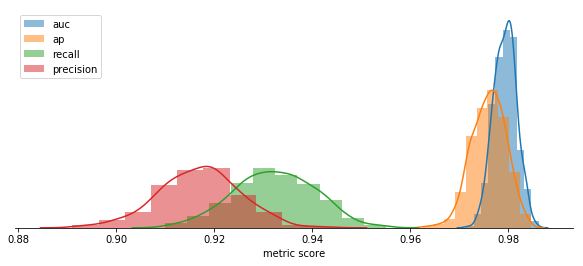

In [224]:
plt.figure(figsize=[10,4])

plt.hist(dict_of_metrics['auc'], density=True, label = 'auc', alpha = 0.5, color = 'C0')
sns.kdeplot(dict_of_metrics['auc'], color = "C0")

plt.hist(dict_of_metrics['ap'], density=True, label = 'ap', alpha = 0.5, color = 'C1')
sns.kdeplot(dict_of_metrics['ap'], color = 'C1')


plt.hist(dict_of_metrics['recall'], density=True, label = 'recall', alpha = 0.5, color = 'C2')
sns.kdeplot(dict_of_metrics['recall'], color = 'C2')


plt.hist(dict_of_metrics['precision'], density=True, label = 'precision', alpha = 0.5, color = 'C3')
sns.kdeplot(dict_of_metrics['precision'], color = 'C3')

plt.legend()
plt.yticks([])
sns.despine(left=True)
plt.xlabel('metric score')

plt.show()

In [ ]:
# #WORKS:
# # Create the training and test sets
# X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=1234)

# # Instantiate the XGBClassifier: xg_cl
# xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, seed=123)

# # Fit the classifier to the training set
# xg_cl.fit(X_train, y_train)

# # Predict the labels of the test set: preds
# preds = xg_cl.predict_proba(X_test)


In [180]:
from sklearn.metrics import auc, average_precision_score, recall_score, precision_recall_curve, roc_auc_score, roc_curve, precision_score
from sklearn.utils.fixes import signature
# tjek https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py

In [181]:
preds050 = (preds[:,1] >= 0.5)*1 # same as standart recall score!
preds035 = (preds[:,1] >= 0.35)*1
preds020 = (preds[:,1] >= 0.20)*1

In [160]:
# preds01 = xg_cl.predict(X_test)
# recall_score(y_test, preds01)

In [161]:
# Recall precision test:

In [182]:
recall_score(y_test, preds050)

0.9374379344587885

In [183]:
recall_score(y_test, preds035)

0.9652432969215492

In [184]:
recall_score(y_test, preds020)

0.9860973187686196

In [185]:
precision_score(y_test, preds050)

0.9147286821705426

In [186]:
precision_score(y_test, preds035)

0.8942042318307267

In [187]:
precision_score(y_test, preds020)

0.8567730802415876

In [168]:
# plots:

In [169]:
average_precision=average_precision_score(y_test,preds[:,1])

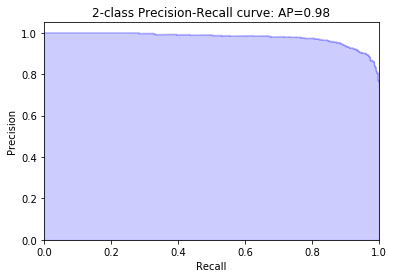

In [188]:
precision, recall, _ = precision_recall_curve(y_test,preds[:,1])


#In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

#plt.plot(recall, precision)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

plt.show()


In [189]:
roc_auc_score(y_test,preds[:,1])

0.9800015200744836

In [190]:
roc_auc_score(y_test,preds[:,1])

0.9800015200744836

In [116]:
roc_auc_score(y_test,preds[:,1])

0.9801886830189283

In [57]:
roc_auc_score(y_test,preds[:,1])

0.9797129928248206

In [58]:
fpr, tpr, thresholds = roc_curve(y_test, preds[:, 1])

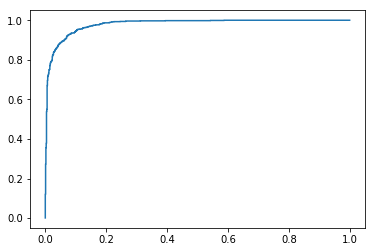

In [59]:
plt.plot(fpr, tpr)
plt.show()

# importance

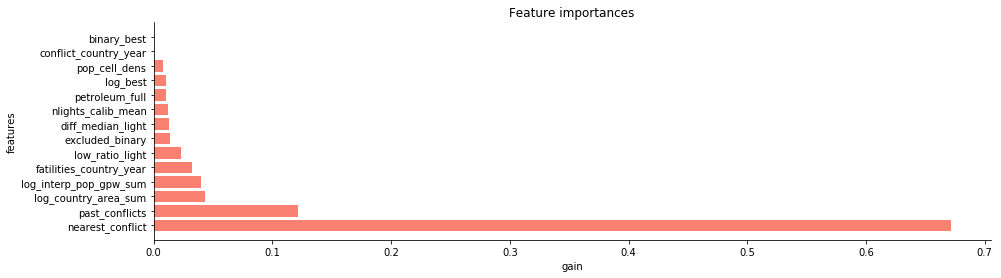

In [60]:
importances = xg_cl.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=[15,int(X.shape[1]/3)])

plt.title("Feature importances")


plt.barh(range(X.shape[1]), importances[indices], color="salmon", align="center")

plt.yticks(range(X.shape[1]),  X.columns[indices])
plt.ylim([-1, X.shape[1]])

plt.xlabel(xg_cl.importance_type)
plt.ylabel('features')

sns.despine()
plt.show()

# OLD SHIT:

In [ ]:
# data_dmatrix = xgb.DMatrix(data=X,label=y)

In [ ]:
xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=3, seed=123, silent=False,n_jobs=-1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


In [ ]:
xg_cl.fit(X_train, y_train, eval_set= [(X_test, y_test)], eval_metric = 'auc', early_stopping_rounds=3,verbose=True)


In [ ]:
print('done')

In [ ]:
xg_cl.fit?

In [ ]:
# # Create arrays for the features and the target: X, y
# X, y = churn_data.iloc[:,:-1], churn_data.iloc[:,-1]

# # Create the training and test sets
# X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=123)

# Instantiate the XGBClassifier: xg_cl
xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=123, silent=False,n_jobs=6)

# Fit the classifier to the training set
xg_cl.fit(X, y)

# # Predict the labels of the test set: preds
# preds = xg_cl.predict(X_test)

# # Compute the accuracy: accuracy
# accuracy = float(np.sum(preds==y_test))/y_test.shape[0]
# print("accuracy: %f" % (accuracy))


In [ ]:
print('done....')

In [ ]:
2

In [ ]:
xgb.XGBClassifier?

In [ ]:
xgb.XGBClassifier().fit

In [ ]:
params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,'max_depth': 5, 'alpha': 10}

In [ ]:
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=123, verbose_eval= True)

In [ ]:
cv_results.head()

In [ ]:
print((cv_results[""]).tail(1))

In [ ]:
np.random.